# Analysis notebook

## High-level overview

As we all know in the UK, the price of living has been increasing a lot these past years. And rent is ever more expensive. Thus, buying a house could be seen as a good idea on the long term.

But buying a house is expensive, if not the most expensive thing you may have to buy in your live.

I have been looking at buying a house for the past months and I have seen that all the houses have very varying prices. I got then curious to look at what could possibly impact the price of a house.

## Description of input data
mIn Kaggle, there is a competition relative to the price of houses. The data used for this competition is a modernized and expanded version of the Boston Housing dataset. Though not english, this dataset is complete enough that I'll use it for this analysis. It will give us an idea of which features in a house are having the most impact on its price.

The data is comprised of two csvs: train and test. The latter does not contain SalePrices, and will be used in the Kaggle competition to test the quality of our model

## Strategy for solving the problem

The two main files from Kaggle are separated. We will concatenate them to make sure we have a full view on the data and its feature's distribution.

We will first do some EDA and Data preprocessing, as the data hasn't been cleaned. Due to the target having a right tail, we will log transform it.
During the data pre-processing, we will:

- Fill the missing values either manually or with a KNN imputer
- Remove outliers
- Create new features
- Use a One-Hot Encoder to encode the categorical features.

Once done, we will use a XGBoost model to predict the Sale Price with a GridSearchCV to tune the parameters of the model. The objective parameter of the XGB will stay the default (reg:squarederror)

The model, in particular, that I have chosen is a  XGBRegressor as the target is numerical (SalePrice).

## Expected solution
We expect the model to predict the SalePrice, with some features to be clearly seen as important:

For example, the quality of the house, its size, the area where the house is placed or the age of the house should be seen as 

## Metrics used

As the target is numerical, we will use a regressor model with RMSE as our internal model.

The final measure used to see the quality of our model will be the one used in Kaggle to rank their competitors.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats
import seaborn as sns
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from xgboost import XGBRegressor, plot_importance, DMatrix

In [2]:
# limits for viewing results
pd.set_option('display.max_columns',100)

## Step 0 - Import the files

We import the files train.csv and test.csv, put them together to make sure they have the same levels. We will pre-process the data on the full dataset to simplify this analysis.

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Step 1 - EDA

In this section, we will look in more details at the data.

In [4]:
# let's look at the sizes of the tables
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


Firstly, we see that the training set contains 1460 rows and 81 columns while the test set contains 1459 rows and 80 columns. The only column missing in the test file is the SalePrice target. We add it with missing values before merging both tables into our modelling data.

In [5]:
# let's add the saleprice to test before merging them
test['SalePrice'] = np.nan

df = pd.concat(
    [
        train,
        test 
    ],
    axis = 0,
    ignore_index= True
)
print(df.shape)

(2919, 81)


In [6]:
# Let's see all columns names
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

On the 81 columns, one is the target, one is an Id column and the 79 others are features that could be used in the model.

In [7]:
# let's look at the types
df.dtypes.value_counts()

object     43
int64      26
float64    12
dtype: int64

On the 81 columns, one is the target, one is an Id column and the 79 others are features that could be used in the model.


When looking at the distribution of the numerical features, we can see that most distribution seem ok. 

MSSubClass, LotFrontage, LotArea, MasVnrArea, BsmtFinSF1 seem to have a very high maximum value with respect to the rest of their distribution, but it is not surprising on itself as we can expect to have some massive houses in the dataset. They are not outliers.


In [8]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


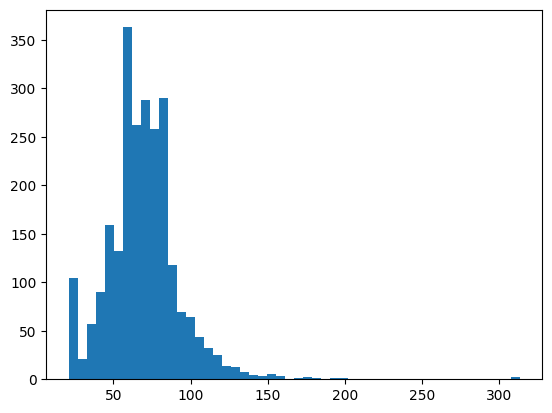

In [9]:
plt.hist(
    df['LotFrontage'],
    bins = 50
);


One error seems to have been added to the GarageYrBlt built feature, which contains a value of 2207. We remove this value as we do not expect the values to be above 2010

In [10]:
df['GarageYrBlt'][df['GarageYrBlt']>2000].value_counts()

2005.0    142
2006.0    115
2007.0    115
2004.0     99
2003.0     92
2008.0     61
2002.0     53
2001.0     41
2009.0     29
2010.0      5
2207.0      1
Name: GarageYrBlt, dtype: int64

In [11]:
df[df['GarageYrBlt']==2207]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2592,2593,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,NaN


In [12]:
df.loc[2592,'GarageYrBlt'] = np.nan

In [13]:
df[df['Id'] == 2593]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2592,2593,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,NaN,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,NaN



When looking at the missing values, we see that 35 columns with missing values:

In [14]:
# Let's look at the 
missing_vals = df.isna().sum()[df.isna().sum()>0]
print(f"We have {len(missing_vals)} columns with missing values")
missing_vals.sort_values()

We have 35 columns with missing values


Electrical         1
GarageArea         1
GarageCars         1
Exterior1st        1
Exterior2nd        1
KitchenQual        1
SaleType           1
TotalBsmtSF        1
BsmtFinSF1         1
BsmtUnfSF          1
BsmtFinSF2         1
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      160
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

Some of these features, like MiscFeature and PoolQC seem to be mostly missing values, which makes sense as we do expect most houses to not have a pool nor miscellanous features like an elevator, a second garage or a tennis court.

We will keep the Id column for now as it will be useful when we will create the submission for Kaggle, but it will be removed later on just before training the XGBoost model.

Let's look now in particular at the target, aka the SalePrice column:

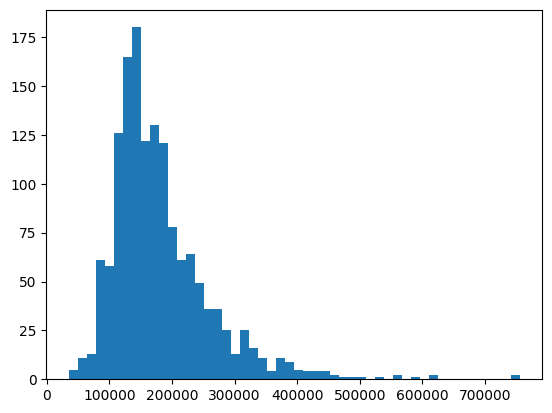

In [15]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

We see that the SalePrice column has a right tail. Let's log the predictions to have a normally distributed target.


In [16]:
# let's log transform the SalePrice column
df['SalePrice'] = np.log(df['SalePrice'])

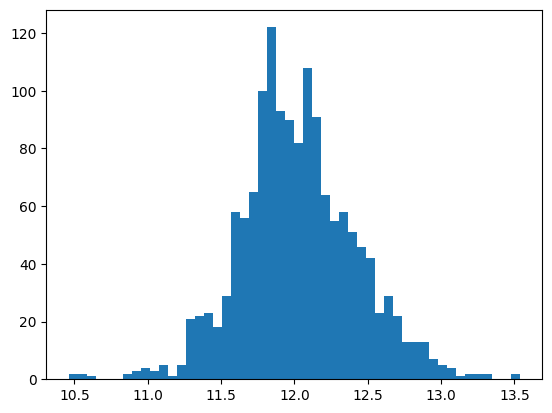

In [17]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

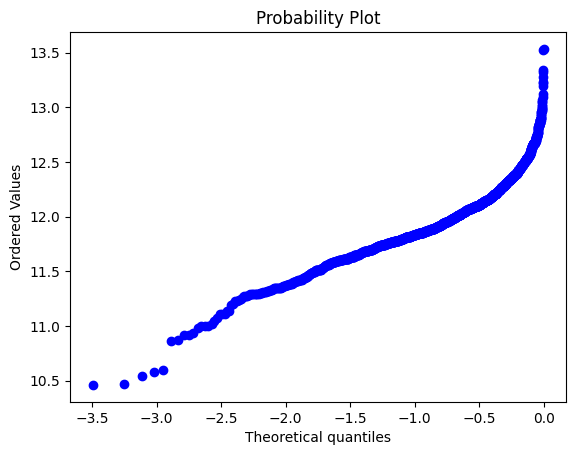

In [18]:
# qq plot
stats.probplot(
    df['SalePrice'],
    dist="norm",
    plot=pylab
)
pylab.show()

We see that 5 sales have very low SalePrices and 2 very high ones.

In [19]:
df[df['SalePrice'] < 10.75]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,649.0,649.0,GasA,TA,N,SBrkr,649,668,0,1317,0.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1.0,250.0,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,10.596635
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495.0,Unf,0.0,225.0,720.0,GasA,TA,N,FuseA,720,0,0,720,0.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,10.460242
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Fa,N,FuseF,334,0,0,334,0.0,0.0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,10.578980
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50.0,Unf,0.0,430.0,480.0,GasA,TA,N,FuseA,480,0,0,480,1.0,0.0,0,0,1,1,TA,4,Typ,0,NaN,Detchd,1958.0,Unf,1.0,308.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,10.471950
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,600.0,600.0,Grav,Fa,N,SBrkr,600,368,0,968,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,10.542706


In [20]:
df[df['SalePrice'] > 13.4]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0.0,1.0,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3.0,832.0,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,13.534473
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,13.521139


After short investigation, we can see that the 5 houses with low SalePrice are very old houses (built before 1950) of below average general condition and usually with an abnormal sale condition.

As for the 2 rows with very high SalePrice, they were built around 1994-6, with overall excellent condition for each check done (Garages, rooms, Kitchen, etc). One even has a pool.

We do not consider these 7 profiles as outliers, and will keep them in the analysis.

## Step 2 - Data Preprocessing

In this section, we will go through nearly each feature and clean them, then we will clean the types of the features, add new features and remove outliers. We will end this step by one-hot encoding the categorical features to be ready to be modelled in the XGBoost model.

### 2.1 Pool variables

In [21]:
print(
    f"""PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with {np.round(missing_vals['PoolQC']/df.shape[0]*100,4)}% of NAs.
""")

PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with 99.6574% of NAs.



<AxesSubplot: xlabel='PoolQC', ylabel='SalePrice'>

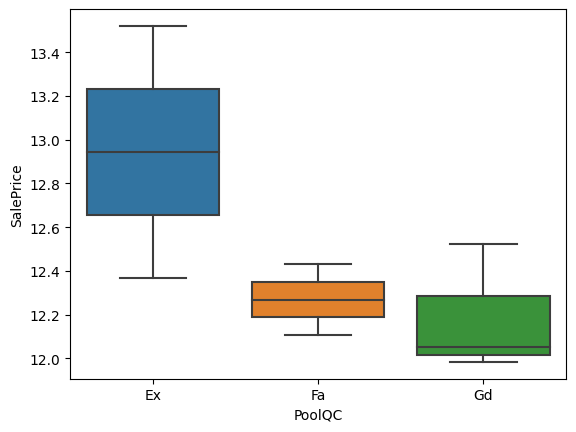

In [22]:
sns.boxplot(
    x = 'PoolQC',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

In [23]:
df[df['PoolQC'].isna()]['PoolArea'].value_counts()

0      2906
368       1
444       1
561       1
Name: PoolArea, dtype: int64

There is another variable called PoolArea, for the area of the pool. When we look at the area if there is a pool or not, we see that the area is most of the time 0 if there is no pool.

We will add "No" as a level, and replace all NAs that have 0 as area by "No". the NAs with PoolArea>0 will be filled based on the Overall quality of the house: 

- if OverallQual is <= 2, returns "Po"
- else, if OverallQual is <= 4, returns "Fa"
- else, if OverallQual is <= 6, returns "TA"
- else, if OverallQual is <= 8, returns "Gd"
- else, returns "Ex"

In [24]:
df['PoolQC'] = df['PoolQC'].map(str)
df['overall_fac'] = np.select(
    [
        df['OverallQual'] <= 2,
        df['OverallQual'] <= 4,
        df['OverallQual'] <= 6,
        df['OverallQual'] <= 8
    ],
    [
        'Po','Fa','TA','Gd'
    ],
    'Ex'
)
df['PoolQC'] = np.select(
    [
        (df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
        (~ df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
    ],
    [ 
        df['overall_fac'],
        df['PoolQC']
    ],
    "No"
)

### 2.2 MiscFeature variable

In [25]:
print(f"If we look at the variable MiscFeature, we see that {np.round(missing_vals['MiscFeature']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

If we look at the variable MiscFeature, we see that 96.4029% of the values are missing. It is an unordered factor.


When looking at the boxplots we see that when there are values, the impact on the sold price is quite significant.


<AxesSubplot: xlabel='MiscFeature', ylabel='SalePrice'>

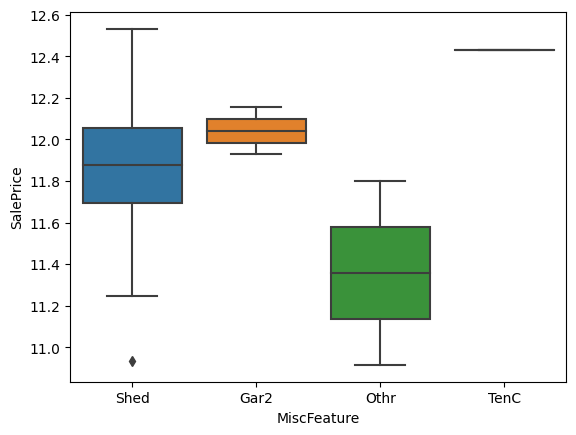

In [26]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We are replacing the missing Misc feature by "No"

In [27]:
df['MiscFeature'] = df['MiscFeature'].fillna('No')

<AxesSubplot: xlabel='MiscFeature', ylabel='SalePrice'>

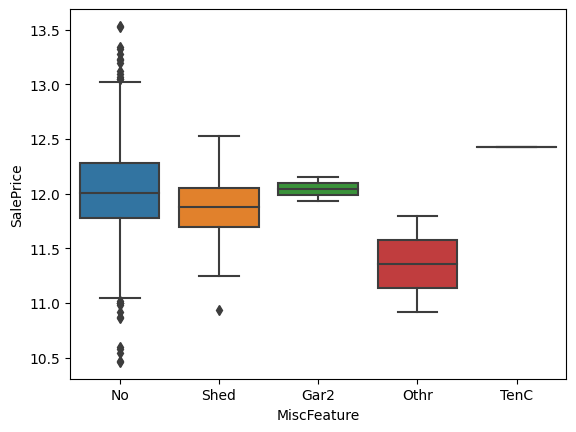

In [28]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.3 Alley variable

In [29]:
print(f"The Alley contains the type of alley to the house, where a missing value means that there is not any alley. {np.round(missing_vals['Alley']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Alley contains the type of alley to the house, where a missing value means that there is not any alley. 93.2169% of the values are missing. It is an unordered factor.


<AxesSubplot: xlabel='Alley', ylabel='SalePrice'>

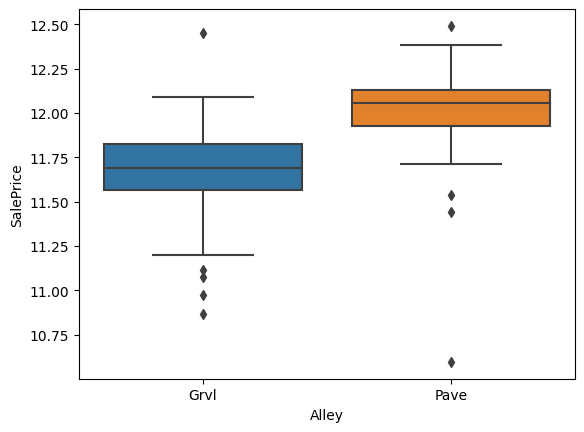

In [30]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No".

In [31]:
df['Alley'] = df['Alley'].fillna('No')

<AxesSubplot: xlabel='Alley', ylabel='SalePrice'>

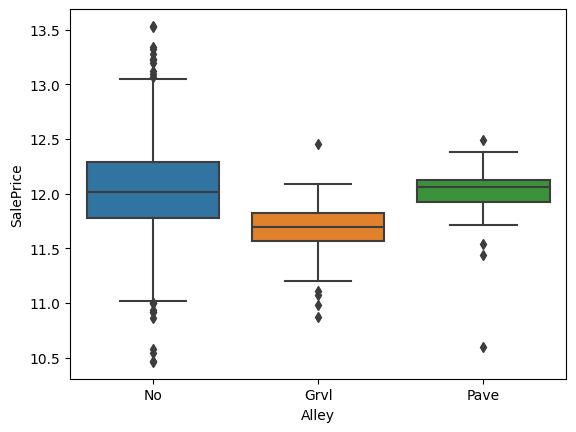

In [32]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.4 Fence variable

In [33]:
print(f"The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. {np.round(missing_vals['Fence']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. 80.4385% of the values are missing. It is an unordered factor.


<AxesSubplot: xlabel='Fence', ylabel='SalePrice'>

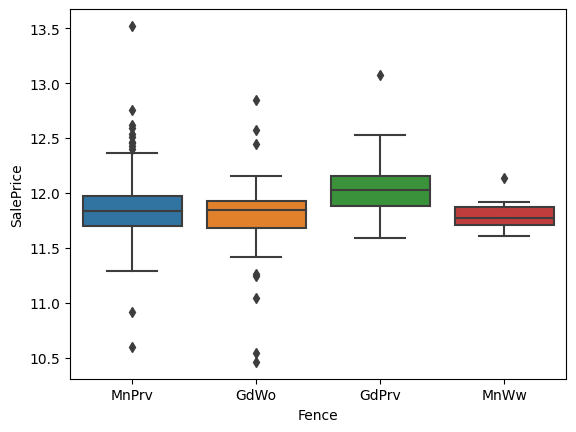

In [34]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

In [35]:
df['Fence'] = df['Fence'].fillna('No')

<AxesSubplot: xlabel='Fence', ylabel='SalePrice'>

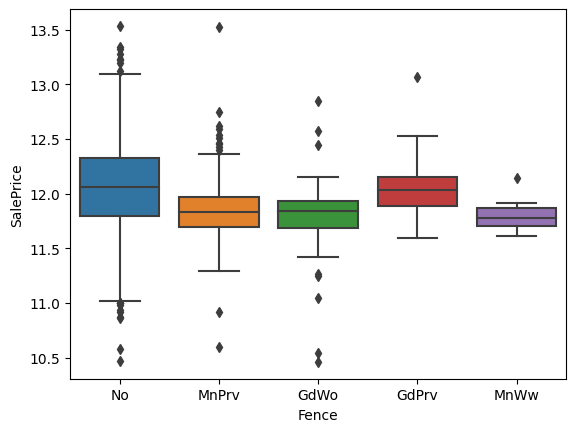

In [36]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.5 Fireplace
There are 2 variables relative to the fireplaces: Fireplaces, counting the number of fireplaces, and FireplaceQu for the fireplace quality.

In [37]:
print(f"The FireplaceQu variable has {np.round(missing_vals['FireplaceQu']/df.shape[0]*100,4)}% missing values. It is an ordered factor.")

The FireplaceQu variable has 48.6468% missing values. It is an ordered factor.


In [38]:
df[df['FireplaceQu'].isna()]['Fireplaces'].value_counts()

0    1420
Name: Fireplaces, dtype: int64

<AxesSubplot: xlabel='FireplaceQu', ylabel='SalePrice'>

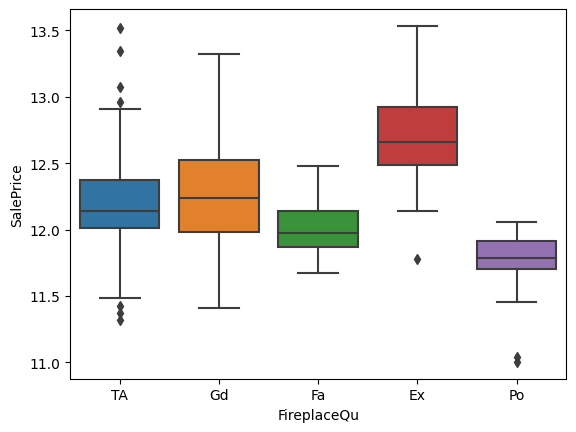

In [39]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No"

In [40]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('No')

<AxesSubplot: xlabel='FireplaceQu', ylabel='SalePrice'>

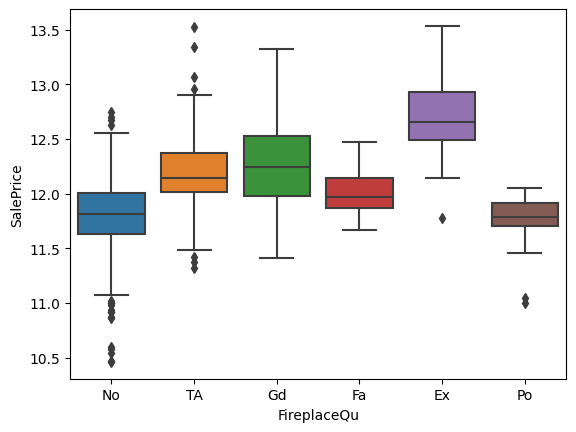

In [41]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.6 LotFrontage variable

In [42]:
print(f"The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with {np.round(missing_vals['LotFrontage']/df.shape[0]*100,4)}% missing values.")


The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with 16.6495% missing values.


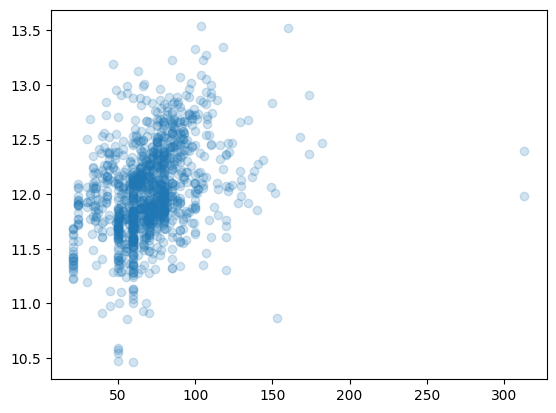

In [43]:
plt.scatter(x = 'LotFrontage',y = 'SalePrice',data = df, alpha = 0.2)

When looking at the scatter plot above, we see that two rows have a LotFrontage value > 300 when all others are < 200. When looking at these profiles in particular, the LotArea valu is quite small. We will keep these values for now but will keep these Ids in memory in kase they are raised again in the future.

In [44]:
df[df['LotFrontage']>250]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,overall_fac
934,935,20,RL,313.0,27650,Pave,No,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,425.0,Unf,0.0,160.0,585.0,GasA,Ex,Y,SBrkr,2069,0,0,2069,1.0,0.0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.0,RFn,2.0,505.0,TA,TA,Y,0,0,0,0,0,0,No,No,No,0,11,2008,WD,Normal,12.396693,Gd
1298,1299,60,RL,313.0,63887,Pave,No,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,No,No,0,1,2008,New,Partial,11.982929,Ex


We will fill this variable with a KNN model

### 2.7 Garage variables
There are 7 variables related to houses' garages.

GarageCars and GarageArea have 1 missing value for the observation Id 2577. This house seems to not have any garage, thus we replace the values of these 2 predictors by 0 and remove the value in GarageType.


In [45]:
df[df['Id'] == 2577]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,overall_fac
2576,2577,70,RM,50.0,9060,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,No,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,No,MnPrv,No,0,3,2007,WD,Alloca,NaN,TA


In [46]:
df['GarageType'] = np.where(
    df['GarageArea'].isna(),
    np.nan,
    df['GarageType']
)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)


In the rows when there is no garage, GarageCars and GarageArea are fixed to 0 and GarageType, GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing. All 5 are ordered factors.

There is a row with Id 2127 where GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing, but GarageArea > 0 and GarageType exists. 

Except for this row, the predictors GarageType, GarageFinish, GarageQual and GarageCond will be filled with a new value "No" and GarageYrBlt will be filled by the year the house was built.

We will fill the row 2127 with a knn method.


In [47]:
df['GarageYrBlt'] = np.where(
    df['GarageYrBlt'].isna() & df['Id'] != 2127,
    df['YearBuilt'],
    df['GarageYrBlt']
)
df['GarageType'] = df['GarageType'].fillna('No')
df['GarageFinish'] = df['GarageFinish'].fillna('No')
df['GarageQual'] = df['GarageQual'].fillna('No')
df['GarageCond'] = df['GarageCond'].fillna('No')

df.loc[2126,['GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']] = np.nan

### 2.8 Basement variables
There are 11 variables related to houses' basements, and all of them have missing values with different percentages:


In [48]:
for col in [col for col in df.columns if col.startswith('Bsmt')]:
    print(f"- There are {np.round(missing_vals[col]/df.shape[0]*100,4)}% missing values for variable {col}")

- There are 2.7749% missing values for variable BsmtQual
- There are 2.8092% missing values for variable BsmtCond
- There are 2.8092% missing values for variable BsmtExposure
- There are 2.7064% missing values for variable BsmtFinType1
- There are 0.0343% missing values for variable BsmtFinSF1
- There are 2.7407% missing values for variable BsmtFinType2
- There are 0.0343% missing values for variable BsmtFinSF2
- There are 0.0343% missing values for variable BsmtUnfSF
- There are 0.0685% missing values for variable BsmtFullBath
- There are 0.0685% missing values for variable BsmtHalfBath


All of these predictors are either ordered factors or numerical.

The row with Id 2121 is NA for all basement variables. We replace the numerical values by 0 and the factor ones by "No".

The row with Id 2189 is the other one with NA for the variables related to Bathrooms in the basement. We replace them with 0.

The rows with Id 2041, 2186 and 2525 contain missing values only for BsmtCond. We replace them with the values in BsmtQual, which are average.

The rows with Id 949, 1488 and 2349 contain missing values only for BsmtExposure. Since for these profiles the BsmtQual and BsmtCond are average, we replace them with the "Av" value.


All other rows, we consider that there is no basement. We replace the missing value by "No" except for BsmtExposure where we will replace it with "None" since the value "No" already exists.


In [49]:
df[df['Id'].isin([2121,2189,2041,2186,2525,948,1488,2349])][[col for col in df.columns if 'Bsmt' in col]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
947,Gd,TA,Av,GLQ,1300.0,Unf,0.0,316.0,1616.0,1.0,0.0
1487,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
2040,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
2188,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
2348,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
2524,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [50]:
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df[col] = df[col].fillna(0)

df['BsmtCond'] = np.where(
    (df['BsmtCond'].isna()) & (~ df['BsmtQual'].isna()),
    df['BsmtQual'],
    df['BsmtCond']
)
df['BsmtQual'] = df['BsmtQual'].fillna('No')
df['BsmtCond'] = df['BsmtCond'].fillna('No')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No')
df['BsmtExposure'] = np.select(
    [
        (df['BsmtExposure'].isna()) & (df['BsmtQual'] != 'No'),
        df['BsmtQual'] == 'No'
    ],
    [
        'Av','None'
    ],
    df['BsmtExposure']
)

# Stopped at line 431 or the EDA.Rmd file.

### 2.9 Masonry veneer variables

In [51]:
print(f"There are 2 variables related to Masonry veneer: MasVnrArea and MasVnrType. The first has {missing_vals['MasVnrArea']} missing values, and the latter {missing_vals['MasVnrType']}.")

There are 2 variables related to Masonry veneer: MasVnrArea and MasVnrType. The first has 23 missing values, and the latter 24.


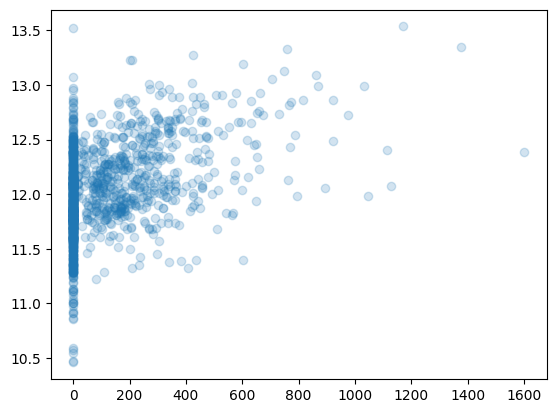

In [52]:
plt.scatter(x = 'MasVnrArea',y = 'SalePrice',data = df, alpha =0.2)

<AxesSubplot: xlabel='MasVnrType', ylabel='SalePrice'>

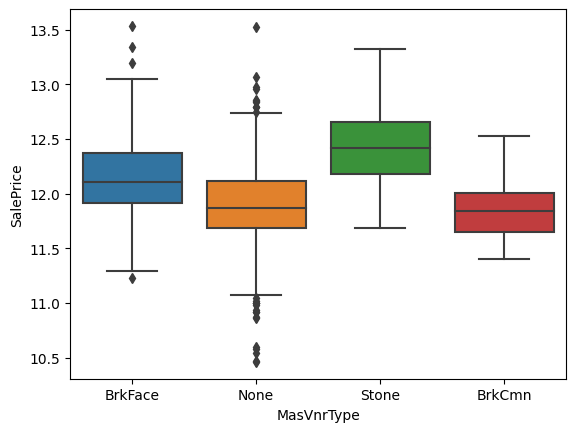

In [53]:
sns.boxplot(
    x = 'MasVnrType',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

In [54]:
df[df['Id'] == 2611]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,overall_fac
2610,2611,20,RL,124.0,27697,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,TA,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,No,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,No,No,No,0,11,2007,COD,Abnorml,NaN,Fa


Row Id 2611 has a missing value for MasVnrType but not MasVnrArea. We will fill MasVnrArea with 0 and  MasVnrType with "None" for all missing values except Id 2611, and use a knn impute for this specific row.


In [55]:
df['MasVnrType'] = np.where(
    df['MasVnrArea'].isna(),
    "None",
    df['MasVnrType']
)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

<AxesSubplot: xlabel='MasVnrType', ylabel='SalePrice'>

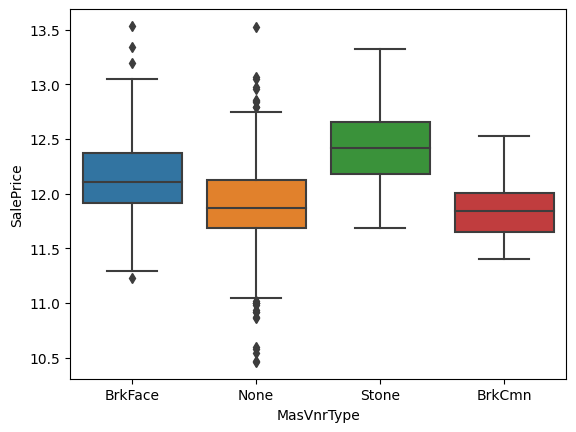

In [56]:
sns.boxplot(
    x = 'MasVnrType',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.10 Other variables with missing values
MSZoning has 4 missing values, Utilities 2, Functional 2, Exterior1st, Exterior2nd, Electrical, KitchenQual and SaleType have 1. All of these are factors, some ordered some not.

We fill these variables with a knn impute.

In [57]:
df['SalePrice'].isna().value_counts()

False    1460
True     1459
Name: SalePrice, dtype: int64

In [58]:
numerical_cols  = list(df.select_dtypes('number'))

# remove SalePrice from the list of feature we want to impute
numerical_cols.remove("SalePrice")

categorical_cols = [col for col in df.columns if col not in numerical_cols]


imputer = KNNImputer(n_neighbors=2)
imputed_numerical = imputer.fit_transform(df[numerical_cols])
imputed_numerical = pd.DataFrame(imputed_numerical)
imputed_numerical.columns = numerical_cols

df = pd.concat(
    [
        df[categorical_cols],
        imputed_numerical
    ],
    axis = 1)

df['PoolArea'] = np.where(
    df['PoolQC'] == 'No',
    0,
    df['PoolArea']
)

In [59]:
# Let's check we didn't fill the SalePrice column
df['SalePrice'].isna().value_counts()

False    1460
True     1459
Name: SalePrice, dtype: int64

### 2.11 Change variable types
Some of the columns received the wrong type when reading the files: either they are written as categorical but should be numerical (and ordered), or they are numerical but should have been categoricals.

Some of the columns that are numerical could be seen as factors instead.

MSSubClass identifies the type of dwelling involved in the sale. It is coded as a numerical variable but is really categorical.

<AxesSubplot: xlabel='MSSubClass', ylabel='SalePrice'>

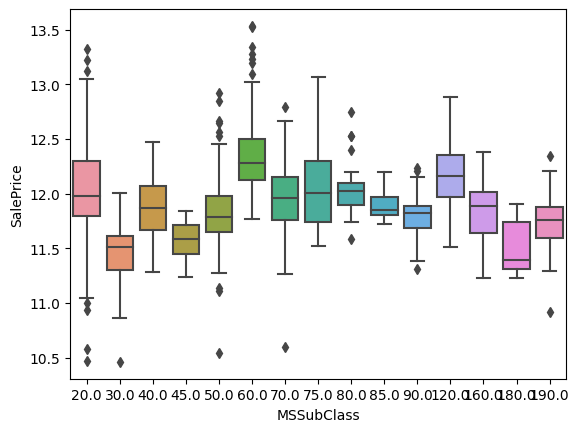

In [60]:
sns.boxplot(
    x = 'MSSubClass',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

MoSold and YrSold give details about the date when the house was sold.


<AxesSubplot: xlabel='MoSold', ylabel='SalePrice'>

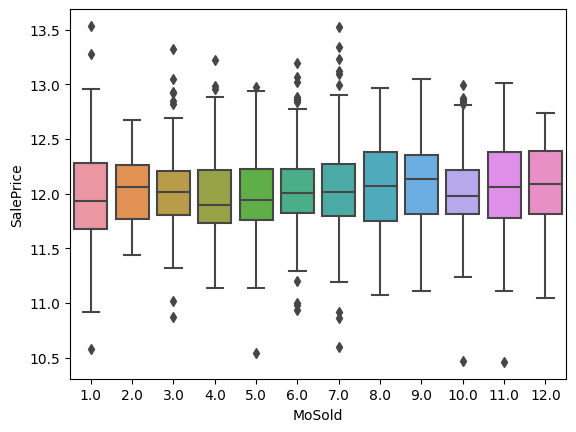

In [61]:
sns.boxplot(
    x = 'MoSold',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

<AxesSubplot: xlabel='YrSold', ylabel='SalePrice'>

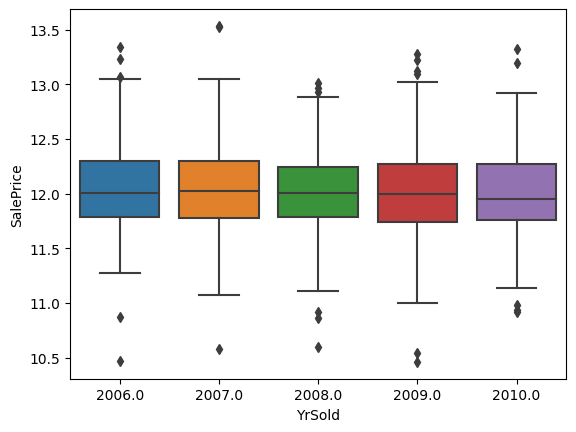

In [62]:

sns.boxplot(
    x = 'YrSold',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We correct these 3 variables to categoricals.


In [63]:
df['MSSubClass'] = pd.Categorical(df['MSSubClass'])
df['MoSold'] = pd.Categorical(df['MoSold'])
df['YrSold'] = pd.Categorical(df['YrSold'])

In [64]:
df.dtypes.value_counts()

object      44
float64     35
category     1
category     1
category     1
dtype: int64

In [65]:
# we finish by correcting all the objects columns to categoricals
for col in list(df.select_dtypes('object')):
    df[col] = pd.Categorical(df[col])

### 2.12 Feature Engineering
Let's group some of the variables together to see if they have a better impact on the SalePrice

Multiple variables describe the number of bathrooms in the houses:

Let's group them together into a TotalBathrooms variable


In [66]:
df['TotalBathrooms'] = df['BsmtFullBath'] + df['FullBath'] + 0.5 * (df['BsmtHalfBath'] + df['HalfBath'])

<AxesSubplot: xlabel='TotalBathrooms', ylabel='SalePrice'>

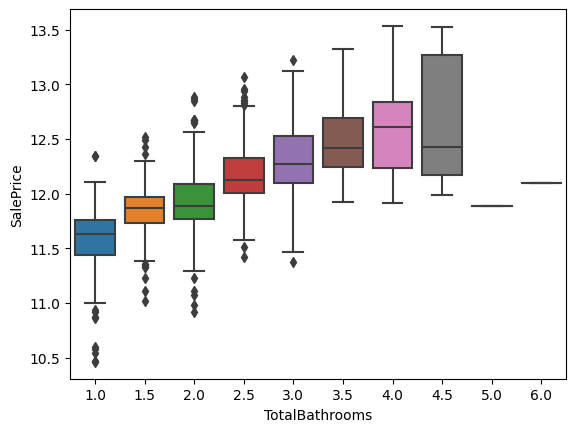

In [67]:
sns.boxplot(
    x = 'TotalBathrooms',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

The number of bathrooms in total seems to have an impact on the sale price.

Another set of features we can create are related to the years features: YearBuilt, YearRemodAdd and YrSold. Since the year of remodel is the same as the year built if there hasnt been any remodelling, we can separate the data if it has been remodeled or not. Same thing, we can calculate the age of the house when it was sold, and if it was "new", aka less than 2 years old.


In [68]:
df['Age'] = df['YrSold'].astype(int) - df['YearBuilt']
df['Remodeled'] = np.where(
    df['YearRemodAdd'] == df['YearBuilt'],
    "Y",
    "N"
)
df['New'] = np.where(df['Age'] < 2, "Y", "N")

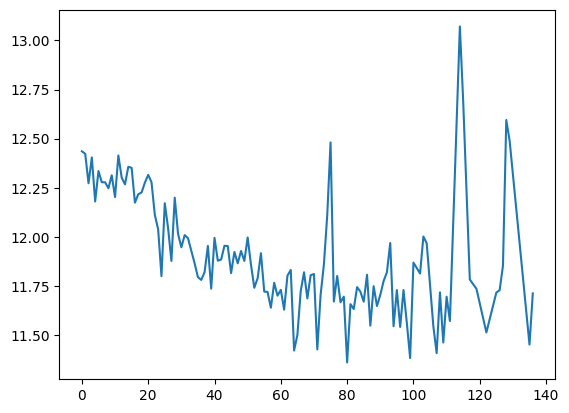

In [69]:
plot_data = df[~ df['SalePrice'].isna()].groupby('Age')['SalePrice'].mean().reset_index()
plt.plot(
    plot_data['Age'],
    plot_data['SalePrice']
)

On average, we can see a difference on the sale price depending on the age of the house. The very high values when the age > 110 is probably due to noise, as most houses will not be as old as that.

<AxesSubplot: xlabel='Remodeled', ylabel='SalePrice'>

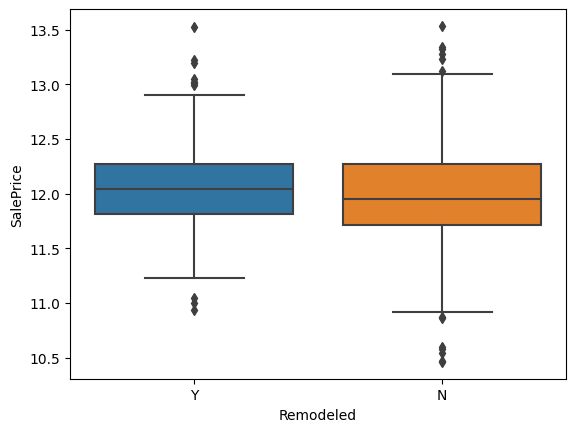

In [70]:
sns.boxplot(
    x = 'Remodeled',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

<AxesSubplot: xlabel='New', ylabel='SalePrice'>

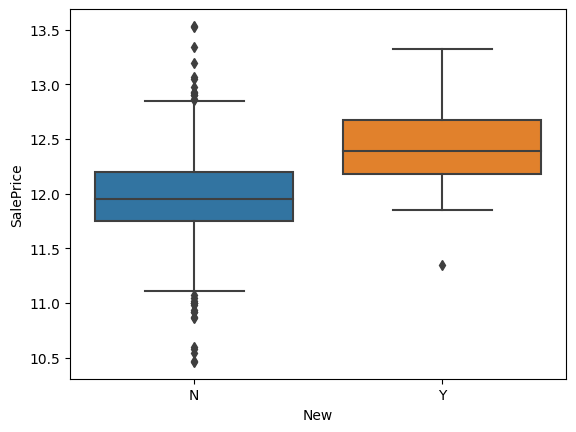

In [71]:
sns.boxplot(
    x = 'New',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

Interestingly, the price for new houses is higher than for older houses. I would have expected the inverse. It is maybe due to the fact that the data is american and not english?

Finally, let's group all the housing area and the porch area.

In [72]:
df['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] +  df['ScreenPorch'] 
df['TotalSquareFeet'] = df['GrLivArea'] + df['GarageArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['LowQualFinSF'] 

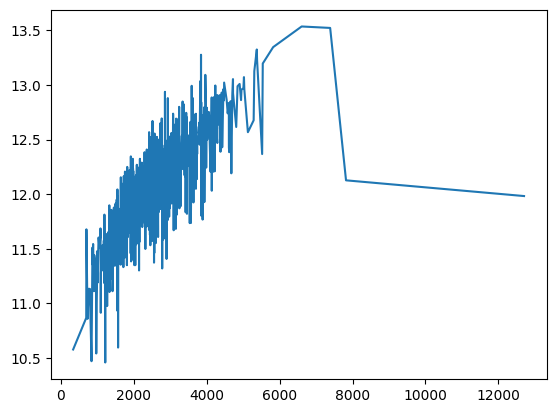

In [73]:
plot_data = df[~ df['SalePrice'].isna()].groupby('TotalSquareFeet')['SalePrice'].mean().reset_index()
plt.plot(
    plot_data['TotalSquareFeet'],
    plot_data['SalePrice']
)

Interestingly, we can see the increase in price depending on the total square feet until ~6000 square feet, then the data drop. We will remove them later-on

### 2.13 Outliers
We sawe earlier that 2 rows seem to have very high values for the total square feet while the sale price stays not very high. Let's check these rows:


In [74]:
df.iloc[ [523,1298], :]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,overall_fac,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBathrooms,Age,Remodeled,New,PorchArea,TotalSquareFeet
523,RL,Pave,No,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,BuiltIn,Fin,TA,TA,Y,No,No,No,New,Partial,12.126759,Ex,524.0,60.0,130.0,40094.0,10.0,5.0,2007.0,2008.0,762.0,2260.0,0.0,878.0,3138.0,3138.0,1538.0,0.0,4676.0,1.0,0.0,3.0,1.0,3.0,1.0,11.0,1.0,2007.0,3.0,884.0,208.0,406.0,0.0,0.0,0.0,0.0,0.0,10.0,2007.0,4.5,0.0,N,Y,614.0,7820.0
1298,RL,Pave,No,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,Hip,ClyTile,Stucco,Stucco,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,Gd,No,No,New,Partial,11.982929,Ex,1299.0,60.0,313.0,63887.0,10.0,5.0,2008.0,2008.0,796.0,5644.0,0.0,466.0,6110.0,4692.0,950.0,0.0,5642.0,2.0,0.0,2.0,1.0,3.0,1.0,12.0,3.0,2008.0,2.0,1418.0,214.0,292.0,0.0,0.0,0.0,480.0,0.0,1.0,2008.0,4.5,0.0,Y,Y,506.0,12704.0


Both of them are new built, with good quality in general and high size. It is probably an error in the dataset.

We remove the two rows containing these profiles.

In [75]:
df = df[ ~ df['Id'].isin([524,1299])].copy()

### 2.14 One Hot Encoding
For the categorical columns it is important to use one hot encoding as the XGBoost will not work as well else.

In [76]:
# features to encode as categorical
features_to_ohe = list(df.select_dtypes('object')) + list(df.select_dtypes('category'))
df[features_to_ohe] = df[features_to_ohe].apply(lambda x: x.astype("category"))

# set up the encoder
ohe = OneHotEncoder(sparse = False,
                    handle_unknown = 'error',
                    drop = 'first')
ohe = ohe.fit(df[features_to_ohe])

# output of encoder
index_name = str(df.index.name)
transformed = pd.DataFrame(ohe.transform(df[features_to_ohe]))
transformed.columns = ohe.get_feature_names_out(features_to_ohe)

# put things back together
df = pd.concat([df.reset_index(drop = True),
                            transformed.reset_index(drop = True)],
                            axis = 1)
# delete input columns
df.drop(features_to_ohe,
                    axis = 1,
                    inplace = True)

## Step 3 - Modelling

Let's start by separating the training dataset from the test dataset. Once we have done that, we separate the train into 2 parts: the one that will be used for training and the one for validation. The validation dataset will contain 20% of the original train.csv file.

In [77]:
train = df[~df['SalePrice'].isna()].copy()
test = df[df['SalePrice'].isna()].copy()

# Let's separate the features from the target
X = train.drop(['SalePrice'], axis = 1, inplace = False)
y = train["SalePrice"]

X.drop('Id', axis=1,inplace = True)
features = X.columns

# Let's create a validation set to remove some ovefitting
X_train,X_validation,y_train,y_validation = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    shuffle = True)

As said in the beginning of this article, we are using a XGBoost model to try to predict our SalePrice target. The objective will stay the default using squared loss.

In [78]:
# Let's try a first XGB model with some parameters
xgb1 = XGBRegressor(
    eta = 0.1,
    gamma = 0.1,
    max_depth = 2
)

xgb1.fit(
        X_train,
        y_train
)

# measure used: RMSE
rmse1 = np.exp(
    np.sqrt(
        MSE(
            y_validation,
            xgb1.predict(X_validation)
        )
    )
)

In [79]:
# predict the test data ans submit it to Kaggle
submission = pd.DataFrame(
    {
        'Id' : test['Id'].astype(int),
        'SalePrice' : np.exp(xgb1.predict(test.drop(['SalePrice','Id'], axis = 1, inplace = False)))
    }
)
submission.to_csv("submission_xgb.csv",index = False)

# when testing it, we got a value of 0.14274

When running a first XGBoost model, we got an RMSE on the validation sample of 1.13914. When submitting the results on Kaggle, we got a score of 0.14274. Let's see if we can improve on that with some tuning.

## Step 4 - Parameter tuning

We will tune the following parameters with a GridSearchCV function:
- eta
- gamma
- max_depth

In [80]:
# init model
xgb = XGBRegressor()
# set up parameters possibilities
params={"eta":[0.05,0.1,0.2,0.3],
        "gamma":[0,0.01,0.1,0.15,0.2],
        "max_depth":[3,4,5,6,7]
       }
gbm_model = GridSearchCV(xgb,
                    params,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 1)

gbm_model.fit(
        X_train,
        y_train
)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.05, 0.1, 0.2, 0.3],
                         'gamma': [0, 0.01, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 5, 6, 7]},
             verbose=1)

In [81]:
# check best parameters
gbm_model.best_params_

{'eta': 0.1, 'gamma': 0, 'max_depth': 5}

## Results

In [82]:
# measure used: RMSE
rmse2 = np.exp(
    np.sqrt(
        MSE(
            y_validation,
            gbm_model.predict(X_validation)
        )
    )
)
print(f"The RMSE of the tuned model is {np.round(rmse2,4)}")

The RMSE of the tuned model is 1.1379


In [83]:
# predict the test data ans submit it to Kaggle
submission = pd.DataFrame(
    {
        'Id' : test['Id'].astype(int),
        'SalePrice' : np.exp(gbm_model.predict(test.drop(['SalePrice','Id'], axis = 1, inplace = False)))
    }
)
submission.to_csv("submission_tuned.csv",index = False)

The RMSE of the tuned model is 1.1379.

When submitting the model predictions to Kaggle, I got a score of 0.13647, which was better than what we had before.

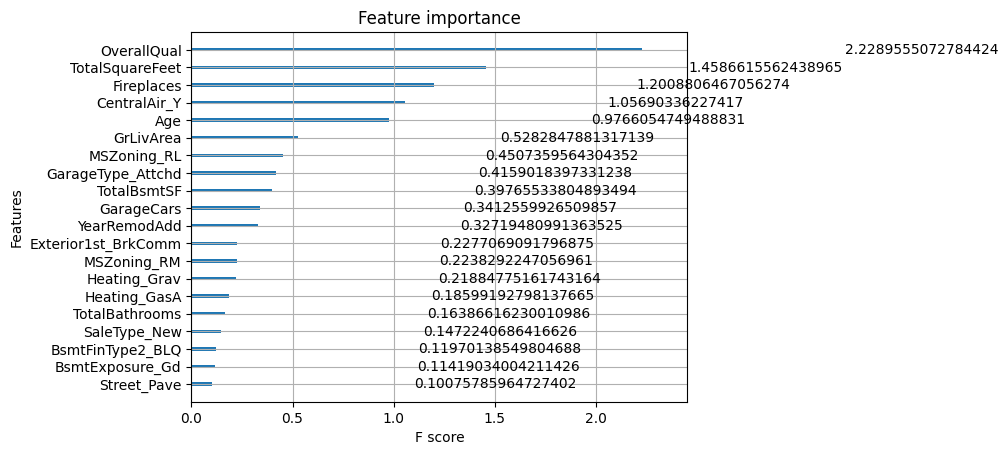

In [84]:
# XGB feature importance plot
plot_importance(
    gbm_model.best_estimator_,
    max_num_features = 20,
    importance_type='gain'   )
X.columns;


When looking at the list of important features we see that the most important feature by far is the overall quality of a house, which makes sense. The better the house, the higher the price.

The next one is the total size of the house, which makes sense too as the bigger the house, the higher the price.

## Comparison table

To summarise what we got before:

In [85]:
pd.DataFrame(
    {
        'models' : ['baseline','tuned'],
        'rmse' : [rmse1, rmse2],
        'Kaggle scores' : [0.14274,0.13647 ],
        'Kaggle rank' : [2053 , 1597]
    }
)

,models,rmse,Kaggle scores,Kaggle rank
0,baseline,1.139143,0.14274,2053
1,tuned,1.137923,0.13647,1597


## Conclusion

The tuned model that we created above seems to improve on our baseline model. With it, our leaderboard ranking in Kaggle jumped from 2053 to 1597. 

While not perfect, this is already a good starting point for improvement.

## Improvement ideas

There are many things that we could have done for the pre-processing of our datasets:

- investigate a possible english dataset to see if we have similar features' impact. For example: are new built having the same impact in England with respect to what we have found here?
- Investigate the houses that had low price but very high square feet.
- We could keep the outliers but transform them in some way.
- We could do a PCA step to remove the multicolinearity instead of just removing columns.
- We could log transform the numerical predictors that are skewed by checking their skewness
- We could test other models